In [1]:
import torchvision
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

import os


In [3]:
total_fase = 2

save_model = True
load_model = False

device = "cuda"
data_dir = "../data" 
batch_size = 32
print("GPU habilitada" , torch.cuda.is_available())

# Conjunto de datos MNIST
train_data = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
eval_data = torchvision.datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)



GPU habilitada True


In [4]:

# Separar las clases 0-4 y 5-9 para los conjuntos de entrenamiento y evaluación

# Conjunto de entrenamiento
train_indices_0_to_4 = [i for i in range(len(train_data)) if train_data.targets[i] < 5]
train_indices_5_to_9 = [i for i in range(len(train_data)) if train_data.targets[i] >= 5]

train_0_to_4 = torch.utils.data.Subset(train_data, train_indices_0_to_4)
train_5_to_9 = torch.utils.data.Subset(train_data, train_indices_5_to_9)

# Conjunto de evaluación
eval_indices_0_to_4 = [i for i in range(len(eval_data)) if eval_data.targets[i] < 5]
eval_indices_5_to_9 = [i for i in range(len(eval_data)) if eval_data.targets[i] >= 5]

eval_0_to_4 = torch.utils.data.Subset(eval_data, eval_indices_0_to_4)
eval_5_to_9 = torch.utils.data.Subset(eval_data, eval_indices_5_to_9)
 

# train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
train_0_to_4_dataloader = DataLoader(train_0_to_4, batch_size, shuffle=True)
train_5_to_9_dataloader = DataLoader(train_5_to_9, batch_size, shuffle=True)

eval_0_to_4_dataloader = DataLoader(eval_0_to_4, batch_size, shuffle=True)
eval_5_to_9_dataloader = DataLoader(eval_5_to_9, batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_data, batch_size=10000, shuffle=True)
print("Se cargaron los datos correctamente")


Se cargaron los datos correctamente


In [5]:

#-----------------------------------------------------------------------------------------
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
for idx,layer in enumerate(model.parameters()):
    if idx >= 4: layer.requires_grad = False

In [6]:
learning_rate = 1e-3
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, t):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    tarjet_prediction = []  # Lista para almacenar las etiquetas reales y predicciones

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Guardar la etiqueta real y la predicción en la lista de tuplas
            tarjet_prediction.extend(list(zip(y.cpu().numpy(), pred.argmax(1).cpu().numpy())))

    test_loss /= num_batches
    correct /= size
    log_accuracy_loss.append((100*correct, test_loss))
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    
    # Definir la ruta del archivo
    directorio= 'logs'
    if not os.path.exists(directorio):
        os.makedirs(directorio)
    with open(f'logs/epoch_{i}_fase_{t}.txt', 'w') as archivo:
            # Escribe el valor de la variable en el archivo
            archivo.write(str(tarjet_prediction))
    print(f'El valor prediciones se ha guardado en el archivo.txt')
    


epochs = 10
data_1 = train_0_to_4_dataloader
data_2 = train_5_to_9_dataloader
log_accuracy_loss = []
for t in range(total_fase):
    print("*" *200)
    print(f"Etapa {t}")


    for i in range(epochs):
        if t == 0:
            print(f"Epoch {i+1}\n-------------------------------")
            train_loop(data_1, model, loss_fn, optimizer)
            test_loop(eval_dataloader, model, loss_fn, t)
        elif t == 1:
            print(f"Epoch {i+1}\n-------------------------------")
            train_loop(data_2, model, loss_fn, optimizer)
            test_loop(eval_dataloader, model, loss_fn, t)

    if save_model: torch.save(model.state_dict(), f'Fase_{t}.pth'); print(f"Se guardo el modelo en la Fase:{t}")


with open(f'logs/log_accuracy_loss.txt', 'w') as archivo:
        # Escribe el valor de la variable en el archivo
        archivo.write(str(log_accuracy_loss))
print(f'Se guardo correctamente el acurracy')

print("Done!")

********************************************************************************************************************************************************************************************************
Etapa 0
Epoch 1
-------------------------------
loss: 2.317926  [   32/30596]
loss: 2.309065  [ 3232/30596]
loss: 2.283777  [ 6432/30596]
loss: 2.237459  [ 9632/30596]
loss: 2.214843  [12832/30596]
loss: 2.202485  [16032/30596]
loss: 2.182613  [19232/30596]
loss: 2.181930  [22432/30596]
loss: 2.130073  [25632/30596]
loss: 2.106693  [28832/30596]
Test Error: 
 Accuracy: 22.1%, Avg loss: 2.270833 

El valor prediciones se ha guardado en el archivo.txt
Epoch 2
-------------------------------
loss: 2.103408  [   32/30596]
loss: 2.054820  [ 3232/30596]
loss: 2.037414  [ 6432/30596]
loss: 1.992456  [ 9632/30596]
loss: 1.994175  [12832/30596]
loss: 1.960678  [16032/30596]
loss: 1.882533  [19232/30596]
loss: 1.875492  [22432/30596]
loss: 1.784496  [25632/30596]
loss: 1.801683  [28832/30596]
Test 

# Fase 0

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import ast
import os


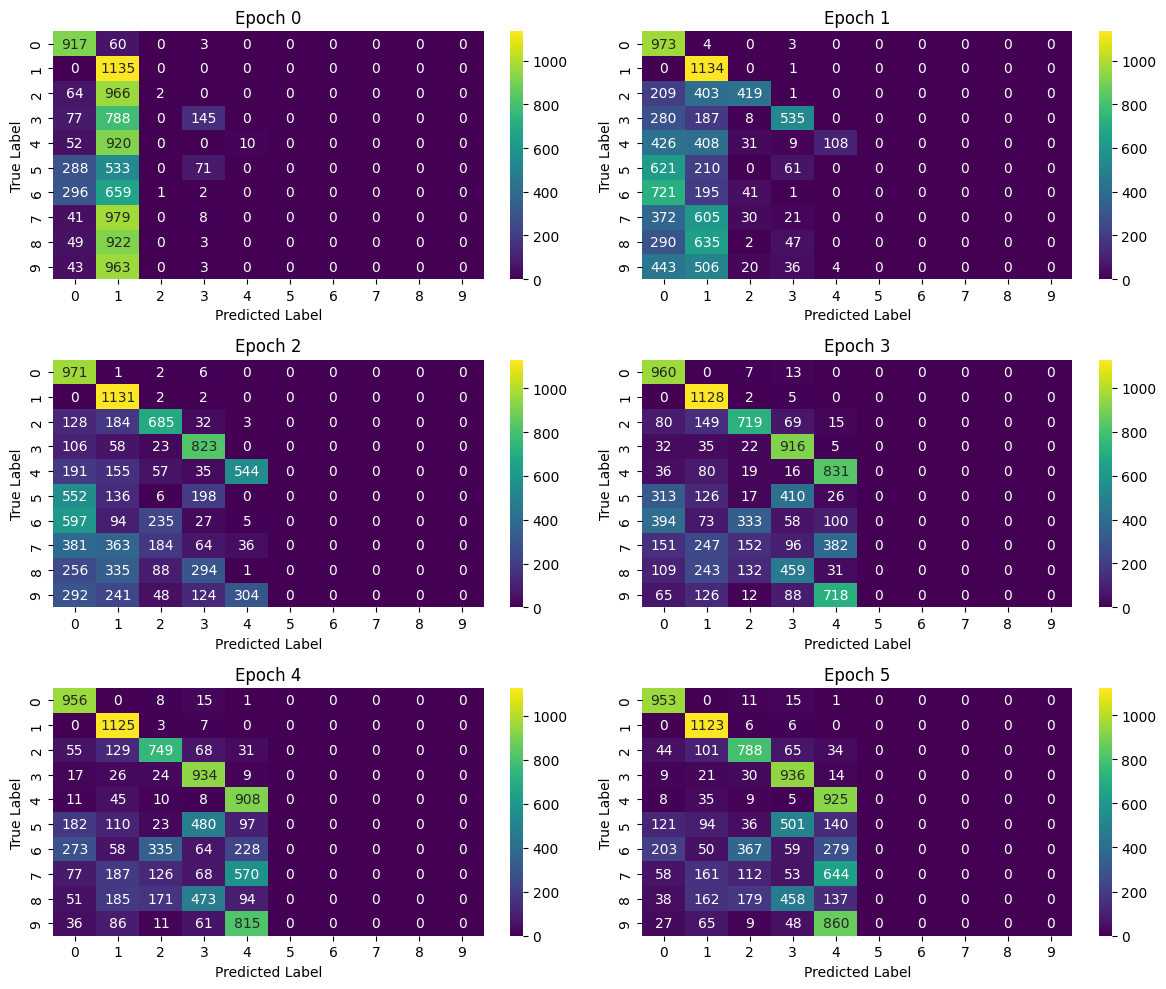

In [8]:

# Configurar la cuadrícula de subgráficos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Iterar sobre los archivos y las ubicaciones de subgráficos
for i, ax in enumerate(axes.flatten()):
    # Crear el nombre del archivo
    file_name = f'logs/epoch_{i}_fase_0.txt'
    
    # Verificar si el archivo existe
    if os.path.exists(file_name):
        # Abre el archivo en modo de lectura ('r')
        with open(file_name, 'r') as archivo:
            # Lee el contenido del archivo
            contenido = archivo.read()
            
            # Convierte la expresión literal de Python en la estructura de datos original
            data = ast.literal_eval(contenido)

        # Extraer etiquetas reales y predicciones
        real_labels, predicted_labels = zip(*data)

        # Crear una matriz de confusión
        conf_matrix = confusion_matrix(real_labels, predicted_labels)

        # Crear un mapa de calor en el subgráfico actual
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                    xticklabels=set(real_labels), yticklabels=set(real_labels), ax=ax)

        # Añadir etiquetas a los ejes
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title(f'Epoch {i}')

# Ajustar diseño y mostrar el mosaico de mapas de calor
plt.tight_layout()
plt.show()


## Fase 1

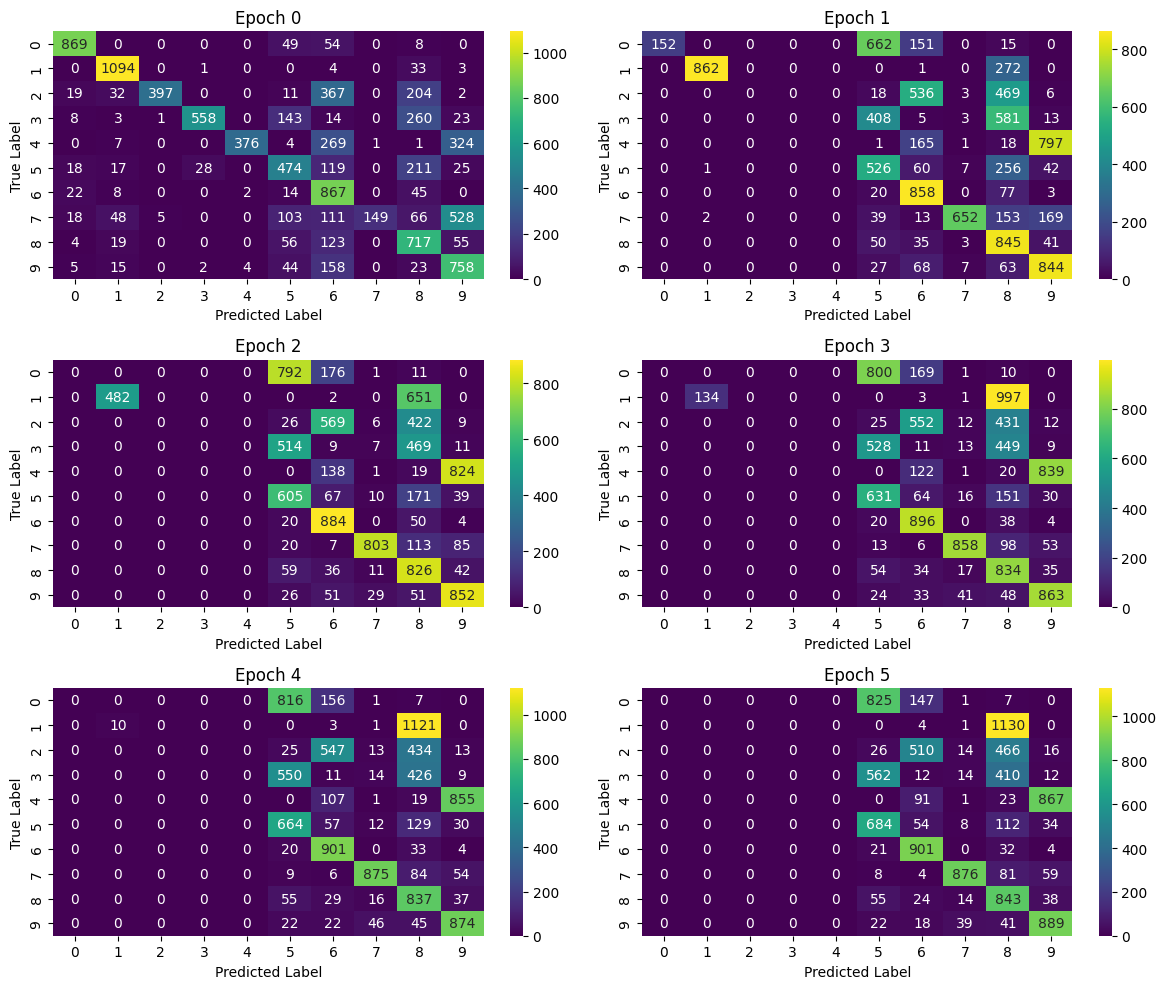

In [9]:

# Configurar la cuadrícula de subgráficos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Iterar sobre los archivos y las ubicaciones de subgráficos
for i, ax in enumerate(axes.flatten()):
    # Crear el nombre del archivo
    file_name = f'logs/epoch_{i}_fase_1.txt'
    
    # Verificar si el archivo existe
    if os.path.exists(file_name):
        # Abre el archivo en modo de lectura ('r')
        with open(file_name, 'r') as archivo:
            # Lee el contenido del archivo
            contenido = archivo.read()
            
            # Convierte la expresión literal de Python en la estructura de datos original
            data = ast.literal_eval(contenido)

        # Extraer etiquetas reales y predicciones
        real_labels, predicted_labels = zip(*data)

        # Crear una matriz de confusión
        conf_matrix = confusion_matrix(real_labels, predicted_labels)

        # Crear un mapa de calor en el subgráfico actual
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                    xticklabels=set(real_labels), yticklabels=set(real_labels), ax=ax)

        # Añadir etiquetas a los ejes
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title(f'Epoch {i}')

# Ajustar diseño y mostrar el mosaico de mapas de calor
plt.tight_layout()
plt.show()


¿Aquí los embeddings entonces cambiaron completamente?

## Weights

Se comprueba que los pesos de la ultima capa si estaban congelados.

In [13]:
import torch; from pprint import pprint

fase_0 = torch.load("Fase_0.pth")
fase_1 = torch.load("Fase_1.pth")


In [15]:
print("Weights Norm:")
wn = [(indice ,torch.norm(row) ) for indice ,row in enumerate(fase_1["linear_relu_stack.4.weight"])]
pprint(wn)
print("Bias:")
bias = [(indice ,row ) for indice ,row in enumerate(fase_1["linear_relu_stack.4.bias"])]
pprint(bias)

Weights Norm:
[(0, tensor(0.5636, device='cuda:0')),
 (1, tensor(0.5873, device='cuda:0')),
 (2, tensor(0.5926, device='cuda:0')),
 (3, tensor(0.5663, device='cuda:0')),
 (4, tensor(0.5677, device='cuda:0')),
 (5, tensor(0.5846, device='cuda:0')),
 (6, tensor(0.5896, device='cuda:0')),
 (7, tensor(0.5789, device='cuda:0')),
 (8, tensor(0.5617, device='cuda:0')),
 (9, tensor(0.5665, device='cuda:0'))]
Bias:
[(0, tensor(-0.0252, device='cuda:0')),
 (1, tensor(-0.0285, device='cuda:0')),
 (2, tensor(-0.0234, device='cuda:0')),
 (3, tensor(-0.0082, device='cuda:0')),
 (4, tensor(-0.0032, device='cuda:0')),
 (5, tensor(0.0170, device='cuda:0')),
 (6, tensor(-0.0114, device='cuda:0')),
 (7, tensor(0.0197, device='cuda:0')),
 (8, tensor(0.0312, device='cuda:0')),
 (9, tensor(-0.0113, device='cuda:0'))]


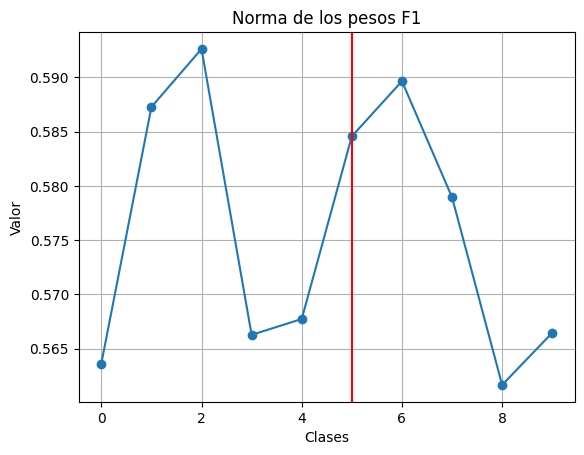

In [16]:
# Convertir los datos en listas separadas para x e y
x = [item[0] for item in wn]
y = [item[1].item() for item in wn]  # Convertir los tensores a valores numéricos

# Crear el gráfico
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Clases')
plt.ylabel('Valor')
plt.title('Norma de los pesos F1')
plt.grid(True)
plt.axvline(5, color = "r")
plt.show()

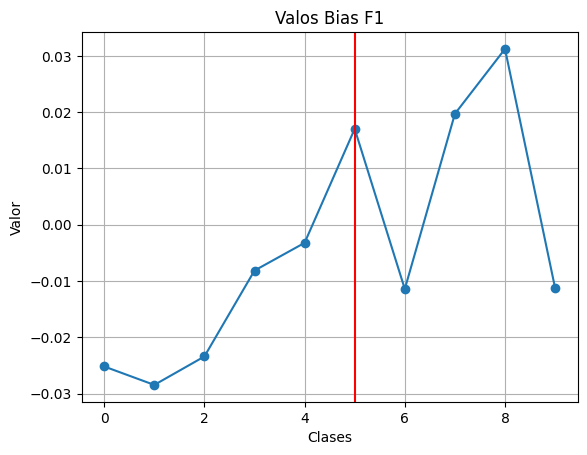

In [17]:
# Convertir los datos en listas separadas para x e y
x = [item[0] for item in bias]
y = [item[1].item() for item in bias]  # Convertir los tensores a valores numéricos

# Crear el gráfico
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Clases')
plt.ylabel('Valor')
plt.title('Valos Bias F1')
plt.grid(True)

plt.axvline(5, color = "r")
plt.show()

## Fase 0

In [18]:
print("Weights Norm:")
wn = [(indice ,torch.norm(row) ) for indice ,row in enumerate(fase_0["linear_relu_stack.4.weight"])]
pprint(wn)
print("Bias:")
bias = [(indice ,row ) for indice ,row in enumerate(fase_0["linear_relu_stack.4.bias"])]
pprint(bias)

Weights Norm:
[(0, tensor(0.5636, device='cuda:0')),
 (1, tensor(0.5873, device='cuda:0')),
 (2, tensor(0.5926, device='cuda:0')),
 (3, tensor(0.5663, device='cuda:0')),
 (4, tensor(0.5677, device='cuda:0')),
 (5, tensor(0.5846, device='cuda:0')),
 (6, tensor(0.5896, device='cuda:0')),
 (7, tensor(0.5789, device='cuda:0')),
 (8, tensor(0.5617, device='cuda:0')),
 (9, tensor(0.5665, device='cuda:0'))]
Bias:
[(0, tensor(-0.0252, device='cuda:0')),
 (1, tensor(-0.0285, device='cuda:0')),
 (2, tensor(-0.0234, device='cuda:0')),
 (3, tensor(-0.0082, device='cuda:0')),
 (4, tensor(-0.0032, device='cuda:0')),
 (5, tensor(0.0170, device='cuda:0')),
 (6, tensor(-0.0114, device='cuda:0')),
 (7, tensor(0.0197, device='cuda:0')),
 (8, tensor(0.0312, device='cuda:0')),
 (9, tensor(-0.0113, device='cuda:0'))]


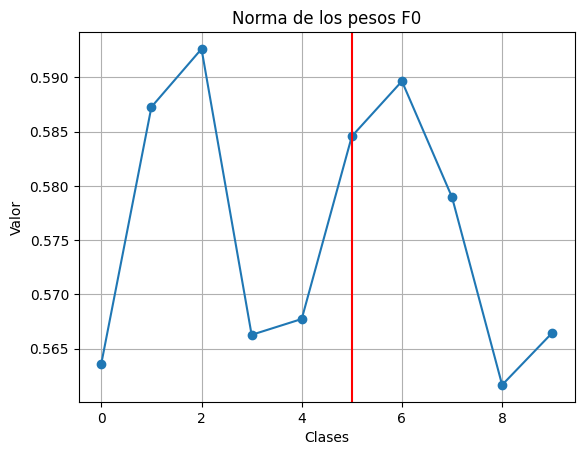

In [19]:
# Convertir los datos en listas separadas para x e y
x = [item[0] for item in wn]
y = [item[1].item() for item in wn]  # Convertir los tensores a valores numéricos

# Crear el gráfico
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Clases')
plt.ylabel('Valor')
plt.title('Norma de los pesos F0')
plt.grid(True)
plt.axvline(5, color = "r")
plt.show()

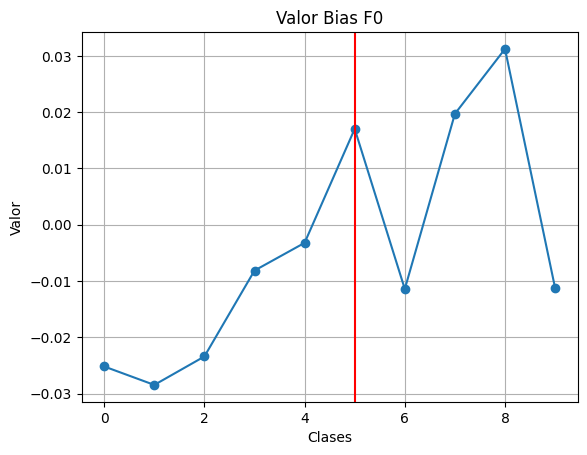

In [20]:
# Convertir los datos en listas separadas para x e y
x = [item[0] for item in bias]
y = [item[1].item() for item in bias]  # Convertir los tensores a valores numéricos

# Crear el gráfico
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Clases')
plt.ylabel('Valor')
plt.title('Valor Bias F0')
plt.grid(True)

plt.axvline(5, color = "r")
plt.show()

In [27]:
fase_1["linear_relu_stack.4.weight"].shape

torch.Size([10, 512])

### Visualización de las caracteristicas

In [90]:
fase_1 = torch.load("Fase_1.pth")
centroid = fase_1["linear_relu_stack.4.weight"].cpu()

In [91]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
        ) 

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [92]:
fase_1 = torch.load("Fase_1.pth")
# Quitamos el clasificador
del fase_1["linear_relu_stack.4.weight"]
del fase_1["linear_relu_stack.4.bias"]

model = NeuralNetwork().to(device)
model.load_state_dict(fase_1)

<All keys matched successfully>

In [93]:
def extractor(dataloader, model):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Obtener las características (vectores de características) del modelo
            features = model(X)
            all_features.append(features.cpu())
            all_labels.append(y.cpu())

    # Concatenar todas las características y etiquetas
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_features, all_labels


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10010 samples in 0.003s...
[t-SNE] Computed neighbors for 10010 samples in 0.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10010
[t-SNE] Computed conditional probabilities for sample 2000 / 10010
[t-SNE] Computed conditional probabilities for sample 3000 / 10010
[t-SNE] Computed conditional probabilities for sample 4000 / 10010
[t-SNE] Computed conditional probabilities for sample 5000 / 10010
[t-SNE] Computed conditional probabilities for sample 6000 / 10010
[t-SNE] Computed conditional probabilities for sample 7000 / 10010
[t-SNE] Computed conditional probabilities for sample 8000 / 10010
[t-SNE] Computed conditional probabilities for sample 9000 / 10010
[t-SNE] Computed conditional probabilities for sample 10000 / 10010
[t-SNE] Computed conditional probabilities for sample 10010 / 10010
[t-SNE] Mean sigma: 1.040361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.622459
[t-SNE] KL 

<Axes: title={'center': 'MNIST data T-SNE projection'}, xlabel='comp-1', ylabel='comp-2'>

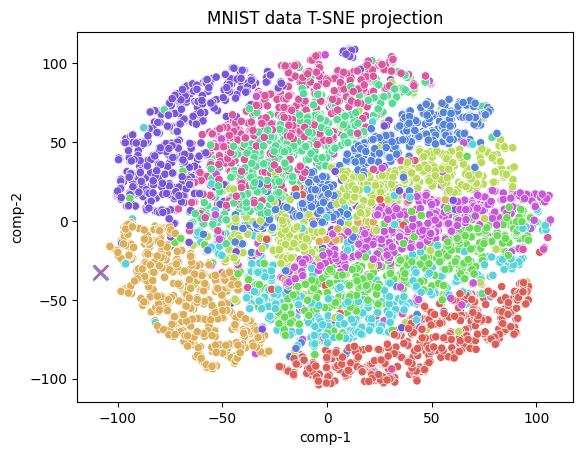

In [94]:

from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd


features, labels = extractor(eval_dataloader, model)
features = torch.cat((features, centroid), dim = 0)
labels = torch.cat((labels, torch.arange(10)), dim = 0)

tsne = TSNE(n_components=2, perplexity=5.0 ,verbose=1, random_state=123)

z = tsne.fit_transform(features)

df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]


# Identificar las últimas 10 filas
ultimas_10 = df.tail(10)

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue="y",
                palette=sns.color_palette("hls", 10),
                data=df[:-10], legend=False).set(title="MNIST data T-SNE projection")

# Marcar las últimas 10 filas con 'x' y su respectivo color
sns.scatterplot(x="comp-1", y="comp-2", hue="y",
                palette=sns.color_palette("hls", 10),
                data=ultimas_10, legend=False, marker="x", s=100)

